In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Permute, Flatten, RepeatVector, Softmax
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [14]:
# 1. Load and prepare data

# Đọc dữ liệu từ CSV
data = pd.read_csv('./stock_data/BTC_2010-2011.csv')

# Chuyển đổi cột 'Date' sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# In ra các cột để kiểm tra
print("Các cột trong dữ liệu:", data.columns)

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Kiểm tra các cột trong dữ liệu
print("Các cột trong dữ liệu:", data.columns)

# Kiểm tra thống kê cơ bản của dữ liệu
print(data.describe())  # Xem thống kê dữ liệu
print("Số lượng giá trị NaN trong mỗi cột:")
print(data.isnull().sum())  # Kiểm tra giá trị NaN
print("Kiểm tra giá trị inf/-inf:")
print(data[data.isin([np.inf, -np.inf]).any(axis=1)])  # Kiểm tra giá trị inf

# Loại bỏ các hàng có giá trị NaN hoặc inf
data = data.dropna()  # Xóa hàng chứa NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Loại bỏ inf/-inf

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Số bước thời gian
timesteps = 100

# Tạo X và y
X = []
y = []

# Xác định vị trí của cột 'Close'
close_index = data.columns.get_loc('Close')

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu của các bước thời gian trước đó cho tất cả các đặc trưng
    X.append(scaled_data.iloc[i - timesteps:i].values)
    # Lấy giá trị 'Close' tại thời điểm i làm mục tiêu dự đoán
    y.append(scaled_data.iloc[i, close_index])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
          Adj Close         Close          High           Low          Open  \
count  34105.000000  34105.000000  34105.000000  34105.000000  34105.000000   
mean   75734.798419  75734.798419  75734.798419  75734.798419  75734.798419   
std     9053.527931   9053.527931   9053.527931   9053.527931   9053.527931   
min    65198.042969  65198.042969  65198.042969  65198.042969  65198.042969   
25%    68153.375000  68153.375000  68153.375000  68153.375000  68153.375000   
50%    72066.203125  72066.203125  72066.203125  72066.203125  72066.203125   
75%    86629.593750  86629.593750  86629.593750  86629.593750  86629.593750   
max    93409.023438  93409.023438  93409.023438  93409.023438  93409.023438   

             Volume  
count  3.410500e+04  
mean   1.745148e+07  
std    1.568273e+0

In [15]:
# Số bước thời gian
timesteps = 100

# Chuẩn hóa toàn bộ dữ liệu trước khi tạo X và y [0, 1]
scaler = MinMaxScaler() 
scaled_data = scaler.fit_transform(data)

# Tạo X và y
X = []
y = []
# for i in range(timesteps, len(data)):
#     X.append(data.iloc[i-timesteps:i, :-1].values)  # Các cột đầu vào
#     y.append(data.iloc[i, 1])  # Giá trị Close của bước tiếp theo

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu từ t-100 đến t
    X.append(scaled_data[i-timesteps:i, :-1])  # Các cột đầu vào
    # Giá trị Close tại thời điểm t+1 làm mục tiêu dự đoán
    y.append(scaled_data[i, 1])  # `1` là vị trí cột Close trong scaled_data

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Shape of X: (34005, 100, 5)
Shape of y: (34005,)


In [16]:
# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (27204, 100, 5) Test size: (6801, 100, 5)


In [17]:
# Hàm Attention block
def attention_block(inputs):
    """
    Attention Mechanism để quyết định trọng số tại mỗi bước thời gian.
    """
    attention = Dense(1, activation='tanh')(inputs)  # Học trọng số
    attention = Flatten()(attention)  # Đưa về dạng 1D
    attention = Softmax()(attention)  # Sử dụng Softmax layer thay vì K.softmax
    attention = RepeatVector(K.int_shape(inputs)[2])(attention)  # Lặp lại trọng số theo chiều features
    attention = Permute([2, 1])(attention)  # Hoán vị để phù hợp với inputs
    weighted_inputs = Multiply()([inputs, attention])  # Nhân trọng số với inputs
    return weighted_inputs

# Xây dựng mô hình với Attention
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Layer 1
lstm_out_1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.1)(lstm_out_1)

# Attention Layer
attention_out = attention_block(lstm_out_1)

# LSTM Layer 2
lstm_out_2 = LSTM(64, activation='relu', return_sequences=False)(attention_out)
lstm_out_2 = Dropout(0.1)(lstm_out_2)

# Output Layer
output = Dense(1)(lstm_out_2)

# Compile mô hình
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100, 128)  │     68,608 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100, 128)  │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 1)    │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 100)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 100)       │          0 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 100)  │          0 │ softmax[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 100, 128)  │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 100, 128)  │          0 │ dropout_3[0][0],  │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     49,408 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,210 (461.76 KB)

 Trainable params: 118,210 (461.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - loss: 1.3010 - mae: 1.3010 - val_loss: 0.2475 - val_mae: 0.2475
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.2432 - mae: 0.2432 - val_loss: 0.2339 - val_mae: 0.2339
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.1762 - mae: 0.1762 - val_loss: 0.0183 - val_mae: 0.0183
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0257 - val_mae: 0.0257
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0224 - val_mae: 0.0224
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 9/50
681/681 ━━━━━━━━━━━━━━━━

In [18]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Hiển thị kích thước đầu ra
print("Shape of predictions:", y_pred.shape)


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
Shape of predictions: (6801, 1)


In [19]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [20]:
# mse = mean_squared_error(y_test_original, y_pred_original)
# mae = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")


MSE: 0.00010086348873363238
MAE: 0.007175250034160391


                     Thời gian  Thực tế (Actual)  Dự đoán (Predicted)  Hiệu (Actual - Predicted)
0    2024-11-13 11:50:00+00:00      68261.335938         68518.959100                -257.623163
1    2024-11-13 11:51:00+00:00      72501.015625         72436.898793                  64.116832
2    2024-11-13 11:53:00+00:00      67413.671875         67436.862828                 -23.190953
3    2024-11-13 11:54:00+00:00      73598.343750         73873.324840                -274.981090
4    2024-11-13 11:56:00+00:00      70705.359375         70463.665576                 241.693799
...                        ...               ...                  ...                        ...
6796 2024-11-19 17:16:00+00:00      87526.867188         87842.914121                -316.046934
6797 2024-11-19 17:17:00+00:00      67420.039062         67400.623442                  19.415620
6798 2024-11-19 17:18:00+00:00      88148.085938         88565.833679                -417.747741
6799 2024-11-19 17:19:00+00:00

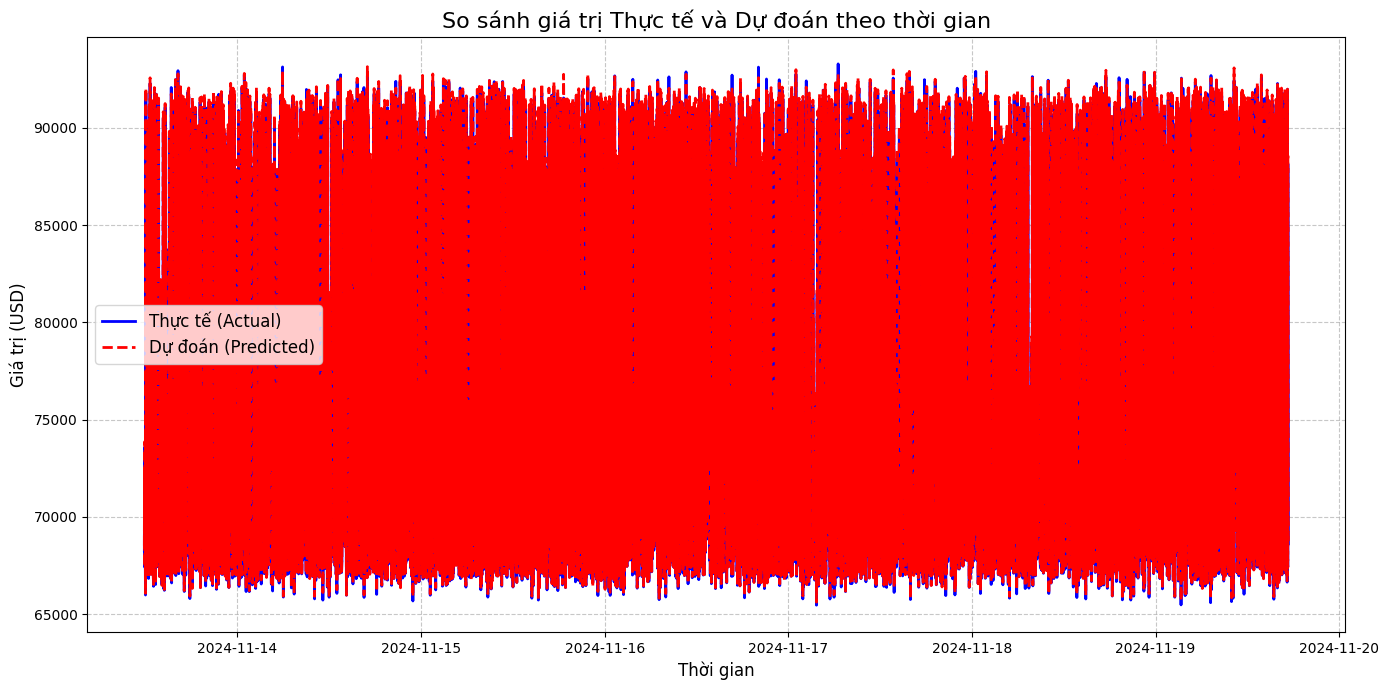

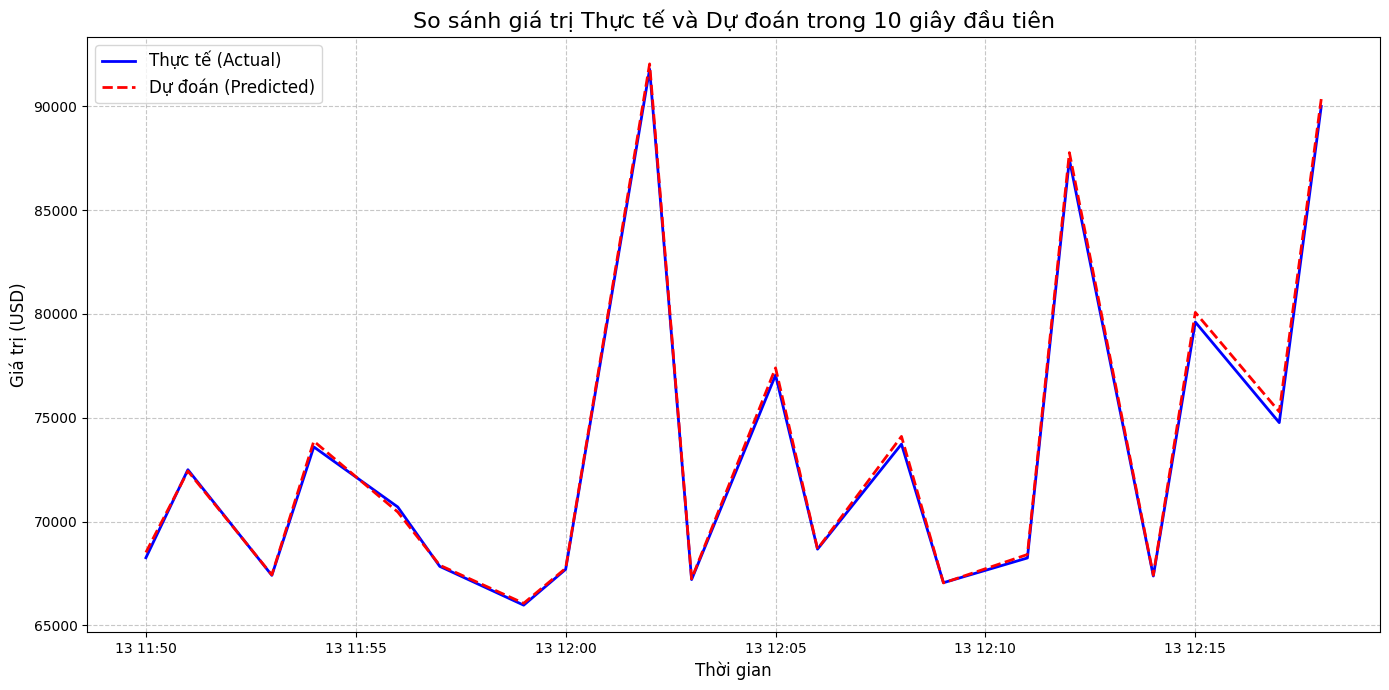

In [21]:
time_index_test = data.index[-len(y_test_original):]  # Lấy thời gian tương ứng với tập test

# Tạo DataFrame chứa thông tin chi tiết từng phút
results_df = pd.DataFrame({
    "Thời gian": time_index_test,  # Cột thời gian
    "Thực tế (Actual)": y_test_original,  # Giá trị thực tế
    "Dự đoán (Predicted)": y_pred_original,  # Giá trị dự đoán
    "Hiệu (Actual - Predicted)": y_test_original.flatten() - y_pred_original.flatten()  # Hiệu giữa thực tế và dự đoán
})

# In kết quả chi tiết
pd.set_option('display.max_columns', None)  # Hiển thị đầy đủ các cột
pd.set_option('display.width', 200)  # Hiển thị ngang dòng
print(results_df)

plt.figure(figsize=(14, 7))
plt.plot(results_df["Thời gian"], results_df["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df["Thời gian"], results_df["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán theo thời gian", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chỉ lấy 10 giây đầu tiên từ DataFrame
results_df_10s = results_df.head(20)

# Vẽ biểu đồ với 10 giây đầu tiên
plt.figure(figsize=(14, 7))
plt.plot(results_df_10s["Thời gian"], results_df_10s["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df_10s["Thời gian"], results_df_10s["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán trong 10 giây đầu tiên", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()